In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tifffile
from ganrec.propagators import TomoRadon


In [2]:
def tfnor_tomo(img):
    # img = tf.image.per_image_standardization(img)
        # img = img / tf.reduce_max(img)
        # img = img - tf.reduce_min(img)
    img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
    return img

(6, 1, 128, 128)


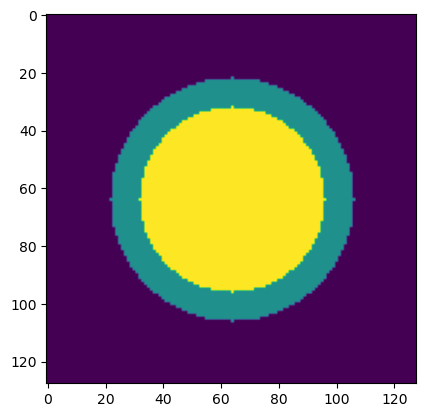

In [4]:
strain_tensor = np.load('/nsls2/users/xyang4/data_tmp/tensor_tomography/strain_tensor.npy')
print(strain_tensor.shape)
plt.imshow(strain_tensor[0,0,:,:])
plt.show()
tifffile.imwrite('/nsls2/users/xyang4/data_tmp/tensor_tomography/strain_tensor.tiff', strain_tensor)
# plt.imshow(strain_)

In [3]:
num_angles = 180
  # Out of plane rotation
psi = 90

    # Convert from degree to radian
angles = np.linspace(0, 180, num_angles)
angles = angles * np.pi / 180
psi = psi * np.pi / 180
num_ang = len(angles)
detector_rows = strain_tensor.shape[1]
detector_columns = strain_tensor.shape[2]

(6, 1, 128, 128)


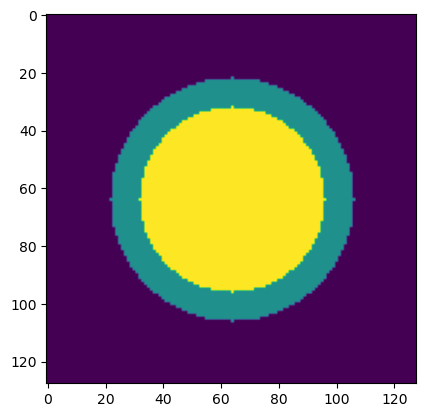

(1, 128, 128)
(1, 128, 128, 1)
(6, 180, 128) <dtype: 'float32'>


2024-05-08 14:45:33.231448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-08 14:45:33.231764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-08 14:45:33.231969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-08 14:45:33.240515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-08 14:45:33.240735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

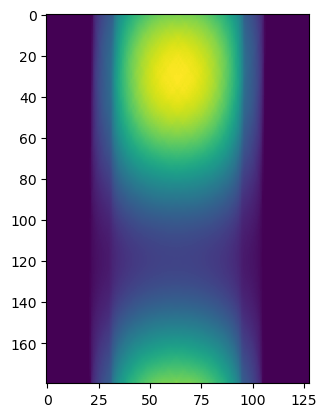

In [2]:
strain_tensor = np.load('/nsls2/users/xyang4/data_tmp/tensor_tomography/strain_tensor.npy')
print(strain_tensor.shape)
plt.imshow(strain_tensor[0,0,:,:])
plt.show()
num_angles = 180
  # Out of plane rotation
psi = 90

    # Convert from degree to radian
angles = np.linspace(0, 180, num_angles)
angles = angles * np.pi / 180
psi = psi * np.pi / 180
num_ang = len(angles)
detector_rows = strain_tensor.shape[1]
# print(f'')
detector_columns = strain_tensor.shape[2]
vol_mask = tf.zeros((detector_rows, detector_columns, detector_columns))
vol_mask = tf.reduce_sum(tf.abs(strain_tensor), axis=0) > 0.0
# vol_mask = 1 * (tf.reduce_sum(tf.abs(strain_tensor), axis=0) > 0.0)
# vol_mask = np.zeros((detector_rows, detector_columns, detector_columns))
# vol_mask = 1 * (np.sum(np.absolute(strain_tensor), axis=0) > 0.0)
print(vol_mask.shape)
vol_mask = tf.reshape(vol_mask, (-1, detector_columns, detector_columns, 1))
print(vol_mask.shape)
# vol_mask = np.reshape(vol_mask, (vol_mask.shape[0], vol_mask.shape[1], vol_mask.shape[2], 1))
vol_mask = tf.cast(vol_mask, dtype=tf.float32)
strain_tensor = tf.cast(strain_tensor, dtype=tf.float32)
angles = tf.cast(angles, dtype=tf.float32)
thickness = TomoRadon(vol_mask, angles).compute()
thickness = tf.squeeze(thickness)
tifffile.imwrite('/nsls2/users/xyang4/data_tmp/tensor_tomography/thickness_tf.tiff', thickness.numpy())
strain_tensor = tf.transpose(strain_tensor, [0, 2, 3, 1])
proj_strain_comp = TomoRadon(strain_tensor, angles).compute()
proj_strain_comp = tf.squeeze(proj_strain_comp)
print(proj_strain_comp.shape, proj_strain_comp.dtype)



# Assuming proj_strain_comp, angles, and self.psi are defined
# Calculate tensor components with appropriate broadcasting
cos_squared = tf.expand_dims(tf.pow(tf.cos(angles), 2), 1)
sin_squared = tf.expand_dims(tf.pow(tf.sin(angles), 2), 1)
cos_psi_squared = tf.pow(tf.cos(psi), 2)
sin_psi_squared = tf.pow(tf.sin(psi), 2)
sin_2angles = tf.expand_dims(tf.sin(2 * angles), 1)
sin_angles_sin_2psi = tf.expand_dims(tf.sin(angles) * tf.sin(2 * psi), 1)
cos_angles_sin_2psi = tf.expand_dims(tf.cos(angles) * tf.sin(2 * psi), 1)

# Applying the strain equations
proj_strain_ws = (tf.multiply(proj_strain_comp[0], cos_squared * sin_psi_squared) +
                  tf.multiply(proj_strain_comp[1], sin_squared * sin_psi_squared) +
                  tf.multiply(proj_strain_comp[2], cos_psi_squared) +
                  tf.multiply(proj_strain_comp[3], sin_2angles * sin_psi_squared) +
                  tf.multiply(proj_strain_comp[4], sin_angles_sin_2psi) +
                  tf.multiply(proj_strain_comp[5], cos_angles_sin_2psi))


# proj_strain_ws = tf.multiply(proj_strain_comp[0], tf.expand_dims(tf.pow(tf.cos(angles), 2) * tf.pow(tf.sin(psi), 2), 1)) + \
#                  tf.multiply(proj_strain_comp[1], tf.expand_dims(tf.pow(tf.sin(angles), 2) * tf.pow(tf.sin(psi), 2), 1)) + \
#                  tf.multiply(proj_strain_comp[2], tf.pow(tf.cos(psi), 2), 1) + \
#                  tf.multiply(proj_strain_comp[3], tf.expand_dims(tf.sin(2 * angles) * tf.pow(tf.sin(psi), 2), 1)) + \
#                  tf.multiply(proj_strain_comp[4], tf.expand_dims(tf.sin(angles) * tf.sin(2 * psi), 1)) + \
#                  tf.multiply(proj_strain_comp[5], tf.expand_dims(tf.cos(angles) * tf.sin(2 * psi), 1))
# proj_strain_ws = tf.where(thickness > 0.05, proj_strain_ws, 0)
# strain_sino = tf.math.divide_no_nan(proj_strain_ws, thickness)
strain_sino = proj_strain_ws
tifffile.imwrite('/nsls2/users/xyang4/data_tmp/tensor_tomography/strain_sino_tf_3.tiff', strain_sino.numpy())
plt.imshow(strain_sino)
plt.show()

(1, 128, 128, 6)
vol_mask shape is (1, 128, 128)
vol_mask shape is (1, 128, 128)
vol_mask shape is (1, 128, 128, 1)
vol_mask shape is (1, 128, 128, 1)
thickness shape is (1, 180, 128, 1)
thickness shape is (180, 128)
proj_strain_ws shape is (180, 128)


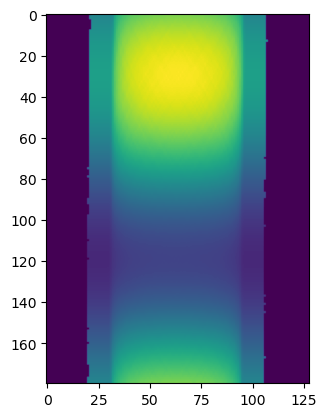

(180, 128)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tifffile
from ganrec.propagators import TensorRadon

strain_tensor = np.load('/nsls2/users/xyang4/data_tmp/tensor_tomography/strain_tensor.npy')
# print(strain_tensor.shape)
# plt.imshow(strain_tensor[0,0,:,:])
# plt.show()
num_angles = 180
psi = 90
angles = np.linspace(0, 180, num_angles)
angles = angles * np.pi / 180
psi = psi * np.pi / 180
strain_tensor = tf.cast(strain_tensor, dtype = tf.float32)
strain_tensor = tf.transpose(strain_tensor, [1, 2, 3, 0])
print(strain_tensor.shape)
strain_sino = TensorRadon(strain_tensor, angles, psi).compute()
plt.imshow(strain_sino)
plt.show()
print(strain_sino.shape)

(6, 1, 128, 128)


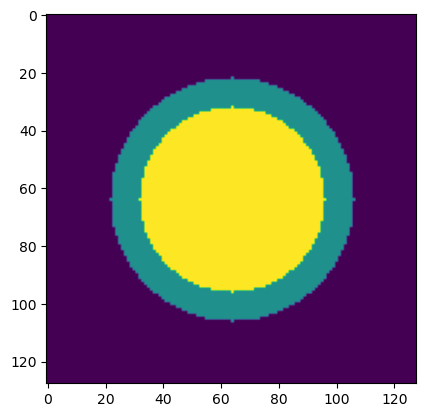

(1, 128, 128, 6)
proj_strain_ws shape is (180, 128)
(6, 180, 128)


2024-05-07 22:04:32.590285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 22:04:32.590548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 22:04:32.590754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 22:04:32.599205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 22:04:32.599420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

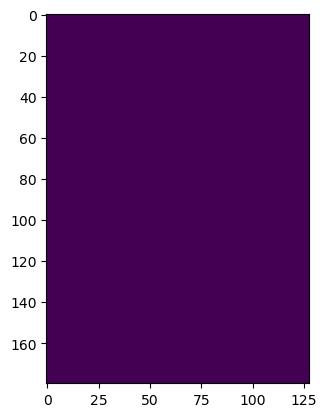

In [20]:
plt.imshow(strain_sino[0])
plt.show()

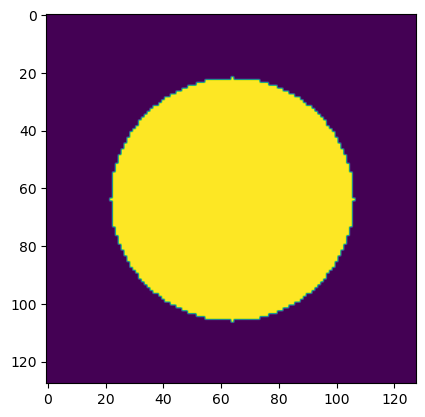

In [5]:
plt.imshow(vol_mask[0,:,:])
plt.show()

In [31]:
print(vol_mask.numpy().max(), vol_mask.numpy().min())

1.0 0.0


(1, 180, 128, 1)


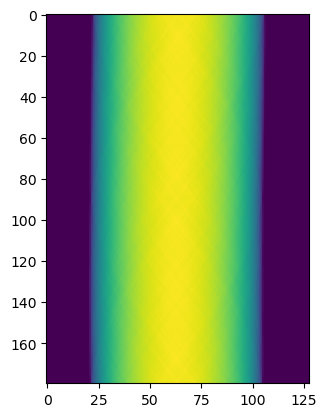

0.6640625 0.0


In [6]:
thickness = TomoRadon(vol_mask, angles).compute()
print(thickness.shape)
plt.imshow(thickness[0, :, :, 0])
plt.show()
print(thickness.numpy().max(), thickness.numpy().min())

In [7]:
thickness = tf.squeeze(thickness)


In [19]:
tifffile.imwrite('/nsls2/users/xyang4/data_tmp/tensor_tomography/thickness_tf.tiff', thickness.numpy())

In [8]:
strain_tensor = tf.transpose(strain_tensor, [0, 2, 3, 1])
proj_strain_comp = TomoRadon(strain_tensor, angles).compute()
print(proj_strain_comp.shape)

(6, 180, 128, 1)


In [12]:
proj_strain_comp = tf.squeeze(proj_strain_comp)
print(proj_strain_comp.shape)


(6, 180, 128)


In [13]:
tf.multiply(proj_strain_comp[0], tf.expand_dims(tf.pow(tf.cos(angles), 2), 1))

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:Mul]

In [5]:
tf.multiply(proj_strain_comp[0], tf.cast(tf.pow(tf.cos(angles), 2), dtype = tf.float32)*tf.cast(tf.pow(tf.sin(psi), 2), dtype=tf.float32))

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:Mul]

In [11]:
tf.multiply(proj_strain_comp[2], tf.pow(tf.cos(psi), 2), 1)

TypeError: can only concatenate str (not "int") to str

In [10]:
proj_strain_ws = tf.multiply(proj_strain_comp[0], tf.expand_dims(tf.pow(tf.cos(angles), 2) * tf.pow(tf.sin(psi), 2), 1)) + \
                 tf.multiply(proj_strain_comp[1], tf.expand_dims(tf.pow(tf.sin(angles), 2) * tf.pow(tf.sin(psi), 2), 1)) + \
                 tf.multiply(proj_strain_comp[2], tf.pow(tf.cos(psi), 2), 1) + \
                 tf.multiply(proj_strain_comp[3], tf.expand_dims(tf.sin(2 * angles) * tf.pow(tf.sin(psi), 2), 1)) + \
                 tf.multiply(proj_strain_comp[4], tf.expand_dims(tf.sin(angles) * tf.sin(2 * psi), 1)) + \
                 tf.multiply(proj_strain_comp[5], tf.expand_dims(tf.cos(angles) * tf.sin(2 * psi), 1))

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:Mul]

In [20]:
tifffile.imwrite('/nsls2/users/xyang4/data_tmp/tensor_tomography/proj_strain_ws_tf.tiff', proj_strain_ws.numpy())

In [11]:
print(proj_strain_ws.shape)

(180, 128)


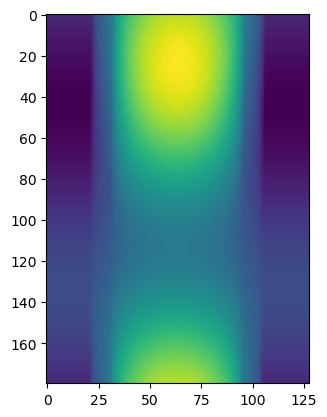

In [12]:
plt.imshow(proj_strain_ws)
plt.show()

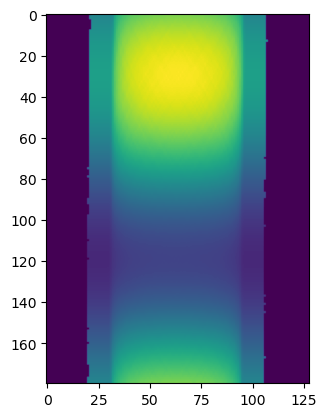

In [11]:
strain_sino = tf.math.divide_no_nan(proj_strain_ws, tfnor_tomo(thickness))
plt.imshow(strain_sino)
plt.show()

In [37]:
import tifffile
tifffile.imwrite('/nsls2/users/xyang4/data_tmp/tensor_tomography/strain_sino_tf_2.tiff', strain_sino.numpy())

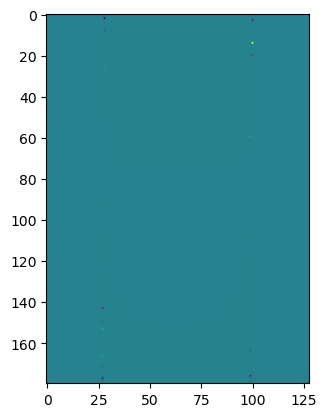